In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# The packages needed to build a portfolio
import scipy.optimize as sco

In [3]:
# data
data=pd.read_csv("https://gwu-workshop-2019-wxs.s3.us-east-2.amazonaws.com/result_csv.csv")
df = data.set_index('Date')
df.head()

,ABMD,ACAD,ALGN,AMED,ANGO,ANIK,ATRC,BASI,BAX,BCRX,...,SGEN,STAA,TECH,TMO,UG,USNA,UTMD,VIVO,WST,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2020/3/2,155.100006,43.759998,230.220001,176.419998,11.75,42.560001,39.110001,4.86,87.180000,3.26,...,111.879997,31.670000,197.639999,304.959992,15.64,70.199997,86.059998,8.31,156.490005,49.650002
2020/3/3,149.179993,41.980000,224.559998,168.330002,11.37,42.150002,38.220001,5.04,85.910004,3.14,...,107.400001,31.370001,193.380005,310.359985,16.74,69.379997,84.050003,8.00,153.979996,47.209999
2020/3/4,154.229996,44.529999,234.699997,175.949997,11.38,43.060001,38.990002,4.86,91.059998,3.51,...,115.980003,32.090000,197.690002,326.640015,15.87,74.919998,84.599998,8.56,158.899994,47.840000
2020/3/5,154.509995,44.389999,230.690002,168.179993,11.31,42.910000,38.040001,4.85,87.650002,3.83,...,118.809998,31.790001,194.080002,312.890015,15.95,72.900002,82.699997,8.23,153.479996,45.320000
2020/3/6,157.080002,41.910000,225.169998,174.300003,11.67,41.410000,36.970001,4.60,85.379997,4.11,...,114.870003,29.770000,194.199997,311.170013,15.41,74.029999,86.000000,8.06,149.949997,44.730000


In [4]:
## calculate returns
returns = np.log(df/df.shift(1))

In [5]:
## number of assets
noa=66 

In [6]:
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000 
risk_free_rate = 0.003

In [7]:
## Function to calculate monthly returns and volatility
def portfolio_monthly_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *21  ## 21 Trading Day
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(21)
    return std, returns
## Use random numbers to set initial weights for portfolio
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(noa)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_monthly_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [8]:
## constraint: sum of weights equaling to 1 
constraints = ({"type":"eq","fun":lambda x: np.sum(x)-1})

In [9]:
## objective function  1：maximize sharpe ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_monthly_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0) ## do not allow short sell
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, noa*[1./noa,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [10]:
## objective function 2：minimize variability
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_monthly_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(noa))

    result = sco.minimize(portfolio_volatility, noa*[1./noa,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [11]:
## calculate efficient frontier 
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_monthly_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, noa*[1./noa,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Monthly Return: 0.17
Monthly Volatility: 0.24


              INO   LMNX   QDEL  RGEN    RVP  VIVO
allocation  12.25  11.48  16.11  30.0  21.15  9.01
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Monthly Return: -0.05
Monthly Volatility: 0.08


            ABMD  BASI   CYAN  DRAD  DYNT  INO  LMNX  PDEX  QDEL  REGN  RGEN  \
allocation  19.9  1.95  38.75  0.92  2.97  1.5  1.72  3.47  7.77  1.88  1.06   

              UG  
allocation  18.1  


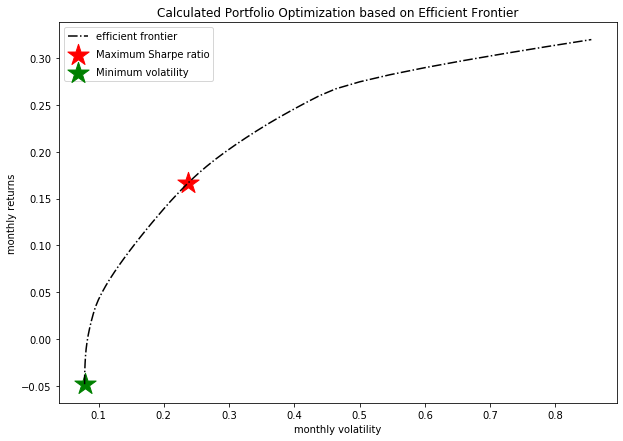

In [12]:
## display result
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_monthly_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation=max_sharpe_allocation[max_sharpe_allocation.allocation>0]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_monthly_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation=min_vol_allocation[min_vol_allocation.allocation>0]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Monthly Return:", round(rp,2))
    print("Monthly Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Monthly Return:", round(rp_min,2))
    print("Monthly Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('monthly volatility')
    plt.ylabel('monthly returns')
    plt.legend(labelspacing=0.8)

display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [13]:
result=df[["INO","LMNX","QDEL","RGEN","RVP","VIVO"]]

In [14]:
result

,INO,LMNX,QDEL,RGEN,RVP,VIVO
Date,,,,,,
2020/3/2,4.39,26.360001,80.730003,88.489998,1.66,8.31
2020/3/3,7.45,27.219999,79.790001,86.650002,1.68,8.00
2020/3/4,8.03,27.290001,82.639999,94.169998,1.70,8.56
2020/3/5,9.80,27.430000,81.059998,93.750000,1.63,8.23
2020/3/6,14.09,27.400000,83.269997,94.470001,1.65,8.06
2020/3/9,9.83,27.209999,80.220001,91.480003,1.47,7.67
2020/3/10,5.70,27.469999,80.930000,95.860001,1.59,6.86
2020/3/11,8.37,27.110001,89.680000,91.000000,1.49,6.43
2020/3/12,9.50,23.090000,81.330002,89.279999,1.26,5.57


Text(0, 0.5, 'price in $')

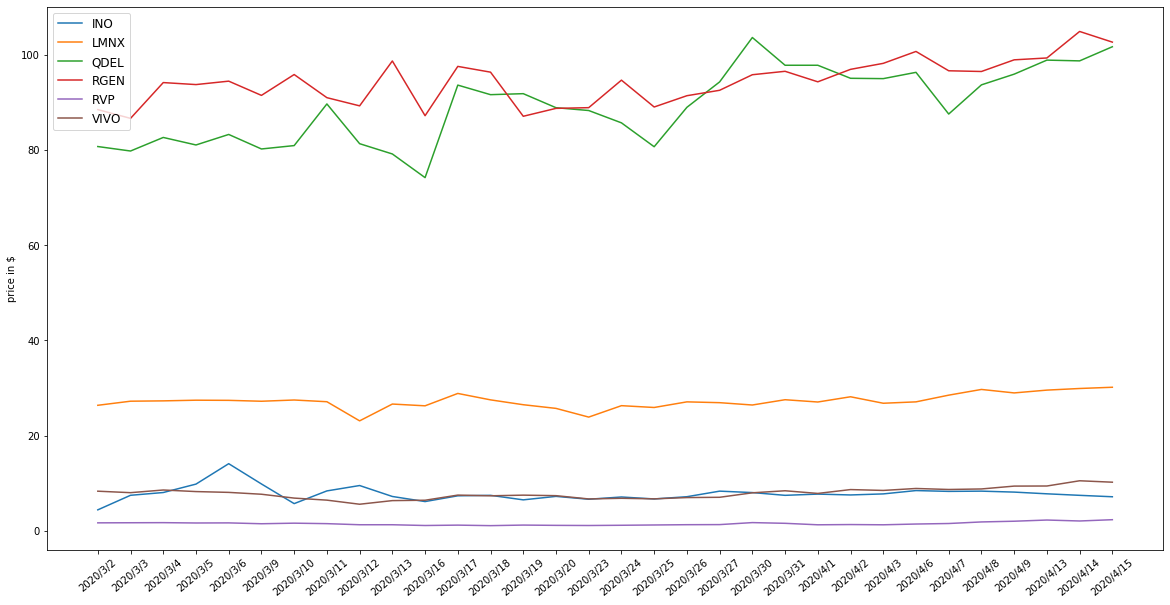

In [15]:
plt.figure(figsize=(20, 10))
for c in result.columns.values:
    plt.plot(result[c],label=c)
plt.xticks(rotation=40)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')